In [1]:
import os 
import pathlib
import pickle as pkl
import cloudpickle 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, StandardScaler, RobustScaler
from sklearn.neural_network import MLPClassifier
pd.set_option('display.max_columns', None)
from bill_classification import *
import shap

In [2]:
shap.initjs()

In [ ]:
SHAP_path = '../out/models/shap_vals.pkl'

with open(SHAP_path, 'rb') as file:
    shap_values, X_test_tr, y_test_sub, y_pred_sub = pkl.load(file)

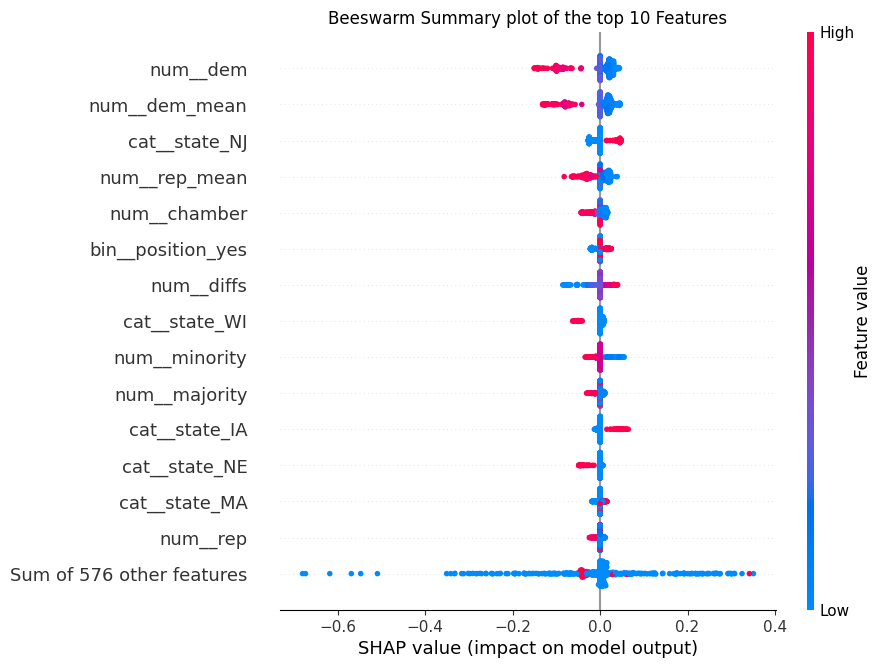

In [30]:
ax = shap.plots.beeswarm(shap_values[:,:,0], max_display=15, show=False)
plt.title("Beeswarm Summary plot of the top 10 Features")
plt.savefig("../out/MLP_eval/beeswarm.png", bbox_inches='tight', dpi = 1000)

In [12]:
ind = 200 #index of target
print(f"true value: {y_test_sub[ind][0]} predicted value: {y_pred_sub[ind]}")

shap.force_plot(shap_values[ind,:,0])

#positions taken is pushing it 

true value: 1 predicted value: 0


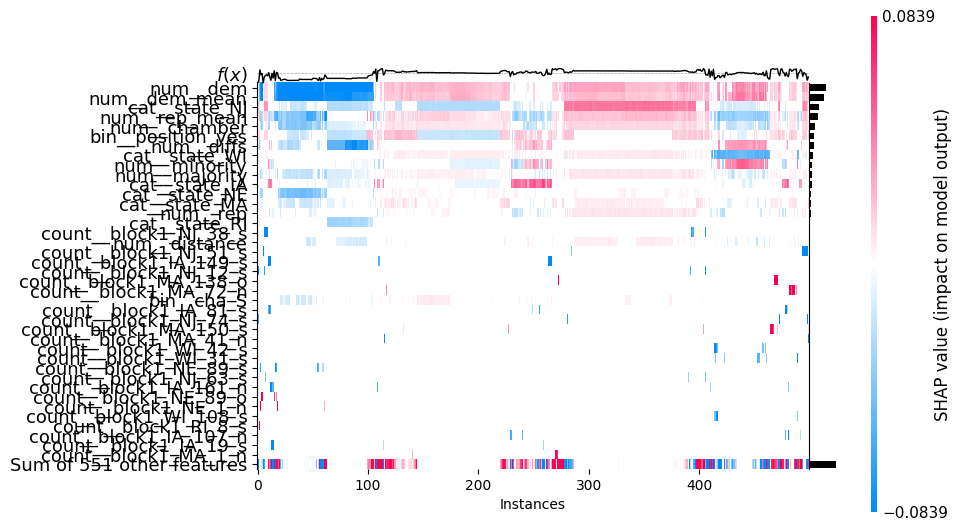

<Axes: xlabel='Instances'>

In [17]:
shap.plots.heatmap(shap_values[:,:,0], max_display=40)